In [ ]:
from regelum.data_buffers.data_buffer import DataBuffer
from regelum.data_buffers.batch_sampler import RollingBatchSampler
from regelum.system import InvertedPendulumPD
import numpy as np
import torch
import casadi as cs
from regelum.model import ModelQuadLin, Model
from regelum.__utilities import rc
from typing import Union
import regelum as rg
from regelum.system import ThreeWheeledRobotNI
import pprint
from regelum.predictor import EulerPredictor

In [13]:
import pandas as pd
from pathlib import Path

p = Path(
    "/mnt/abolychev/regelum_data/mlflow-artifacts/32/3791d0344899432bbbc15a4c39e8e25c/artifacts/.callbacks/HistoricalDataCallback/"
)

pd.read_hdf(p / "observations_actions_it_00200_ep_00004.h5")

,time,running_objective,current_value,episode_id,iteration_id,v_x,v_y,x,y
0,0.00,2000.000000,20.000000,3,199,5.356934,4.811253,-10.000000,-10.000000
1,0.01,1979.715473,39.797155,3,199,5.790299,4.342394,-9.946431,-9.951887
2,0.02,1959.606292,59.393218,3,199,5.576942,5.572957,-9.888528,-9.908464
3,0.03,1937.595015,78.769168,3,199,7.187768,5.715816,-9.832758,-9.852734
4,0.04,1912.280949,97.891977,3,199,4.527567,4.343293,-9.760881,-9.795576
...,...,...,...,...,...,...,...,...,...
996,9.96,8.183013,1793.532110,3,199,1.418625,0.991654,0.751488,0.503555
997,9.97,8.499095,1793.617101,3,199,0.807840,-0.047221,0.765674,0.513472
998,9.98,8.618609,1793.703287,3,199,1.918519,-0.920385,0.773752,0.512999
999,9.99,8.825597,1793.791543,3,199,-0.742441,-0.434857,0.792937,0.503796


In [5]:
import numpy as np
from regelum.system import KinematicPoint
from regelum.simulator import CasADi

system = KinematicPoint()
simulator = CasADi(
    system,
    max_step=0.001,
    state_init=np.array([-10, -10]),
    time_final=10,
)

In [4]:
from scipy.stats import truncnorm
import numpy as np

In [403]:
import matplotlib.pyplot as plt

x = np.linspace(-0.0, 2.0, 1000)


loc = 0.8
scale = 0.2
myclip_a = -1
myclip_b = 1
a, b = (myclip_a - loc) / scale, (myclip_b - loc) / scale

# plt.plot(x, truncnorm(loc=loc, scale=scale, a=a, b=b).pdf(x))

normal = Normal(loc=loc, scale=scale)

x = truncnorm(loc=loc, scale=scale, a=a, b=b).rvs(6)
x_th = torch.FloatTensor(x)
print(truncnorm(loc=loc, scale=scale, a=a, b=b).logpdf(x))
print(
    normal.log_prob(x_th)
    - torch.log(
        normal.cdf(torch.FloatTensor([1])) - normal.cdf(torch.FloatTensor([-1]))
    )
)

[0.68327431 0.58674899 0.79191742 0.86151383 0.59435005 0.60815597]
tensor([0.6833, 0.5867, 0.7919, 0.8615, 0.5944, 0.6082])


In [331]:
from scipy.stats import norm

norm(loc=loc, scale=scale).pdf(np.linspace(-10, 10, 1001)).sum() * np.diff(
    np.linspace(-10, 10, 1001)
).mean()

1.0000000000000002

In [332]:
np.diff(np.linspace(-10, 10, 1001)).mean()

0.02

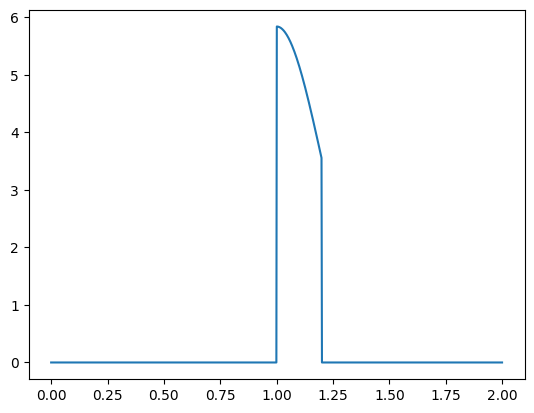

In [343]:
import matplotlib.pyplot as plt

x = np.linspace(-0.0, 2.0, 1000)

plt.plot(x, truncnorm(loc=loc, scale=scale, a=a, b=b).pdf(x))

In [334]:
truncnorm(loc=loc, scale=scale, a=a, b=b).pdf().sum() * np.diff(
    np.linspace(-10, 10, 1000)
).mean()

TypeError: rv_continuous_frozen.pdf() missing 1 required positional argument: 'x'

In [252]:
import torch

from torch.distributions.normal import Normal

torch.exp(torch.FloatTensor([0.38171513]))

tensor([1.4648])

In [261]:
normal.cdf(torch.FloatTensor([b])) - normal.cdf(torch.FloatTensor([a]))

tensor([0.7475])

In [213]:
normal.cdf(torch.FloatTensor([a]))

tensor([0.])

In [256]:
normal

<bound method Normal.cdf of Normal(loc: 0.800000011920929, scale: 0.30000001192092896)>

In [11]:
import random
import numpy as np


controllers = "sdpg","ppo","ddpg","reinforce","dqn","sarsa","rpo","rql","rql_torch","sql","sql_torch","rpo_torch","mpc_torch","mpc"
systems = "3wrobot_ni","cartpole","inv_pendulum","kin_point"
for controller, system zip(controllers, np.tile(systems, len(controllers)))


np.vstack((controllers,np.tile(systems, len(controllers))[:len(controllers)])).T

array([['sdpg', '3wrobot_ni'],
       ['ppo', 'cartpole'],
       ['ddpg', 'inv_pendulum'],
       ['reinforce', 'kin_point'],
       ['dqn', '3wrobot_ni'],
       ['sarsa', 'cartpole'],
       ['rpo', 'inv_pendulum'],
       ['rql', 'kin_point'],
       ['rql_torch', '3wrobot_ni'],
       ['sql', 'cartpole'],
       ['sql_torch', 'inv_pendulum'],
       ['rpo_torch', 'kin_point'],
       ['mpc_torch', '3wrobot_ni'],
       ['mpc', 'cartpole']], dtype='<U12')

In [5]:
import casadi as cs
import numpy as np
import torch

backend = cs.DM


(backend([[1, 1], [2, 2]]).T - backend([[2], [4]])).T ** 2

DM(
[[1, 9], 
 [0, 4]])

In [1]:
import casadi as cs
import numpy as np
import torch

from regelum.constraint import EllipseConstraint, LinearConstraint

In [2]:
constraint1 = EllipseConstraint(coefs=[1, 1, 0], centers=[1, 1, 0], radius=1)
constraint2 = EllipseConstraint(coefs=[2, 2, 0], centers=[0, 0, 0], radius=3)

constraint = constraint1 + constraint2

In [12]:
constraint = LinearConstraint([0, 1, 0], bias=-1) * LinearConstraint(
    [0, -1, 0], bias=-1
)

constraint(cs.DM([[0, -0.5, 0]]))

DM(-0.5)

In [3]:
constraint(cs.MX.sym("x", 2, 3))

MX(min(vertcat(max((ones(2x1)-mac(sq((x'-repmat([1, 1, 0], 2))'),[1, 1, 0],zeros(2x1)))), max((all_9(2x1)-mac(sq((x'-repmat(zeros(3x1), 2))'),[2, 2, 0],zeros(2x1)))))))

In [ ]:
np.array([])

In [ ]:
data_buffer = DataBuffer(20)
pp = pprint.PrettyPrinter(depth=3)

for batch in data_buffer.iter_batches(
    batch_size=4,
    n_batches=2,
    keys=["observation", "action"],
    mode="backward",
    dtype=cs.DM,
):
    print("\nPrinting batch")
    print(
        "Action shape:",
        batch["action"].shape,
        "| Observation shape: ",
        batch["observation"].shape,
    )
    pp.pprint(batch)

In [ ]:
class TestOpt(rg.Optimizable):
    def __init__(self, opt_config):
        super().__init__(opt_config)
        self.create_variable("")

In [23]:
pr = EulerPredictor(ThreeWheeledRobotNI(), 0.01, 1)
x1 = rc.DM([[5.0, 5.0, 2.36]])
acts = rc.DM([[10.0, 0.0]])

x2 = pr.predict_sequence(x1, acts)
x2

DM([[4.92902, 5.07044, 2.36]])

In [ ]:
ModelQuadLin(quad_matrix_type="diaginal", weights=np.array([1, 10, 1, 0, 0]))

In [1]:
from regelum import FunctionWithSignature, VarContainer, Optimizable
from regelum.optimizable.core.configs import casadi_default_config

In [14]:
def f(x, y):
    return x + y

In [31]:
f_signed = FunctionWithSignature(f)

In [20]:
opt = Optimizable(casadi_default_config)
x_var = opt.create_variable(1, 1, name="x")

In [27]:
x_var.as_constant()

OptimizationVariable(name='x', dims=(1, 1), data=None, metadata=MX(opti4_x_1), is_constant=True, hooks=<regelum.optimizable.core.entities.ChainedHook object at 0x7f6e1d350e50>)

In [28]:
x_var.is_constant

True

In [32]:
f_signed.declare_variables(x_var)

FunctionWithSignature(func=<function f at 0x7f6e1d2fdee0>, variables=VarContainer:
  x
  data: None
  metadata: opti4_x_1
  dims: (1, 1)
  is_constant: True


  , is_objective=False, metadata=None)

In [34]:
f_signed.constants_to_substitute

['x']

In [36]:
f_signed.set_parameters(x=1)

In [38]:
f_signed(y=2)

3

In [ ]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import Any
from typing import List, Union
from typing_extensions import Self
from regelum import RegelumBase
from regelum.__utilities import rc


class Constraint(RegelumBase, ABC):
    @abstractmethod
    def __call__(self, observation) -> Any:
        pass

    def __add__(self, right: Union[Self, ComposedConstraint]):
        return ComposedConstraint(constraints=[self, right])

    def __mul__(self, right: Union[Self, ComposedConstraint]):
        return ComposedConstraint(constraints=[self, right], is_union=False)


class LinearConstraint(Constraint):
    def __init__(self, weights, bias) -> None:
        self.weights = weights
        self.bias = bias

    def __call__(self, state) -> Any:
        weights_col = rc.force_column(rc.array(self.weights, prototype=state))
        return rc.max(state @ weights_col + self.bias)


class EllipseConstraint(Constraint):
    def __init__(self, coefs, centers, radius) -> None:
        self.coefs = coefs
        self.centers = centers
        self.radius = radius

    def __call__(self, state, coefs, centers, radius) -> Any:
        centers_column = rc.force_column(rc.array(self.centers, prototype=state))
        coefs_column = rc.force_column(rc.array(self.coefs, prototype=state))
        return rc.max(
            self.radius**2 - (state.T - centers_column).T ** 2 @ coefs_column
        )


class ComposedConstraint(Constraint):
    def __init__(self, constraints: List[Constraint], is_union=True):
        self.constraints = constraints
        self.is_union = is_union

    def __call__(self, state) -> Any:
        violations = rc.vstack([constraint(state) for constraint in self.constraints])
        return rc.min(violations) if self.is_union else rc.max(violations)

    def __add__(self, right: Union[Constraint, Self]):
        return ComposedConstraint(constraints=[self, right])

    def __mul__(self, right: Union[Constraint, Self]):
        return ComposedConstraint(constraints=[self, right], is_union=False)

In [1]:
from regelum.optimizable.core.configs import OptimizerConfig
from regelum import FunctionWithSignature, VarContainer, Optimizable
from regelum.optimizable.core.configs import casadi_default_config


class B:
    def __init__(self, var_container, vars_to_handle):
        self.var_container = var_container
        self.vars_to_handle = vars_to_handle

    def push_data_to_vars(self):
        vars_selected = self.var_container.selected(self.vars_to_handle)
        vars_selected.substitute_data(**{name: 1 for name in vars_selected.names})


class A(Optimizable):
    def __init__(self, optimizer_config: OptimizerConfig) -> None:
        super().__init__(optimizer_config)
        self.x = self.create_variable(1, 1, name="x")
        self.y = self.create_variable(1, 1, name="y", is_constant=True)
        self.z = self.create_variable(1, 1, name="z", is_constant=True)
        self.register_objective(self.f, variables=[self.x, self.y, self.z])
        self.register_constraint(self.constr, variables=[self.x, self.y])

    def get_b_instance(self):
        return B(self.variables, ["y", "z"])

    def constr(self, x, y):
        return 2 * y - x

    def f(self, x, y, z):
        return x**2 + y**2 + z**2

In [2]:
a = A(casadi_default_config)

In [3]:
b = a.get_b_instance()

In [4]:
a.y.metadata

MX(opti0_p_1)

In [5]:
b.push_data_to_vars()

In [6]:
# a.optimize(x=10, raw=True)
a.optimize(x=10, raw=True)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 173.00us ( 28.83us)  14.46us (  2.41us)         6
       nlp_g  | 214.00us ( 35.67us)  17.65us (  2.94us)         6
  nlp_grad_f  | 281.00us ( 40.14us)  22.32us (  3.19us)         7
  nlp_hess_l  | 127.00us ( 25.40us)  10.86us (  2.17us)         5
   nlp_jac_g  | 174.00us ( 24.86us)  14.36us (  2.05us)         7
       total  |  85.01ms ( 85.01ms)   7.11ms (  7.11ms)         1


{'constr': DM(-6.26583e-10), 'f': DM(6), 'x': DM(2)}

In [7]:
a.opt_status

'success'

In [8]:
a.constr(3.97054e-05, 1)

1.9999602946

In [18]:
import numpy as np

np.float32(0.2324554634) * np.float32(0.4325234523)

0.10054244

In [9]:
32324554634 * 34325234523

1109547918663576429582

In [9]:
a.constraints

FuncContainer:
  FunctionWithSignature(func=<bound method A.constr of <__main__.A object at 0x7f7685a284d0>>, variables=VarContainer:
  x
  data: None
  metadata: opti0_x_1
  dims: (1, 1)
  is_constant: False


  y
  data: None
  metadata: opti0_p_1
  dims: (1, 1)
  is_constant: True


  , is_objective=False, metadata=MX(((2.*opti0_p_1)-opti0_x_1)))
  

In [6]:
a.opti.value_parameters()

[MX((2==opti0_p_1)), MX((1==opti0_p_2))]